# plot a few sample tracks from each model just to contextualize the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import xarray
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, date, timedelta
import traceback
import os
import math

import json

from datetime import datetime

from netCDF4 import Dataset
import netCDF4

## helper methods

In [2]:
def getIndexObs(linesinfo, date):
    indexForObs = 0
    for lineinfo in linesinfo:
        lineinfosplit = lineinfo.strip().split()
        if lineinfosplit[0] == 'Year':
            continue
        elif lineinfosplit[0] == date[:4] and lineinfosplit[1] == date[4:6] and lineinfosplit[2] == date[6:8]:
            break
        indexForObs += 1
    return indexForObs

In [3]:
#purpose: checks (boolean) whether a given position of forecast genesis is within a 5-degree circle of the location of the
#         observation corresponding to the forecast genesis time. Degree here means lat/lon degrees.
#param forecastGenesis: the forecast genesis time as a string with values separated by spaces. Specifically, 'year month day hour'
#param forecastLon: longitude of forecast genesis location, type int
#param forecastLat: latitude of forecast genesis location, type int
#param obsTrack: array of the observation track that corresponds to this forecast track. For context, this will be one of
#                the 562 observation tracks that are in the LPS_track_India_1979_2019_JJAS.txt file

def checkCorrespondingPosition(forecastGenesis, forecastLon, forecastLat, obsTrack):
    forecastTime = forecastGenesis
    forYear, forMonth, forDay, forHour = forecastTime[0], forecastTime[1], forecastTime[2], forecastTime[3]
    matchingTimestampDetected = False
    for position in obsTrack:
        if int(position[-4]) == int(forYear) and int(position[-3]) == int(forMonth) and int(position[-2]) == int(forDay) and int(position[-1]) == int(forHour):
            matchingTimestampDetected = True
            if math.sqrt( (float(position[2])-float(forecastLon))**2 + (float(position[3])-float(forecastLat))**2 ) <= 5:
                return True
            
    if matchingTimestampDetected == False:
        weightedAvgLon, weightedAvgLat = interpolate(forecastGenesis, obsTrack)
        #if obsTrack[0][-4] == 2008 and obsTrack[0][-3] == 9 and obsTrack[0][-2] == 8:
         #   print(forecastGenesis, weightedAvgLon, weightedAvgLat)
        
        #now check the 5 degree condition
        if math.sqrt( (float(weightedAvgLon)-float(forecastLon))**2 + (float(weightedAvgLat)-float(forecastLat))**2 ) <= 5:
            return True
        
    return False

In [4]:
#purpose: interpolate missing lon/lat data due to a missing timestamp
#returns: either the interpolated lon and lat coordinates, or 9999 and 9999 if the track has already ended or not yet begun
def interpolate(timestamp, obsTrack):
    splitTimestamp = timestamp
    forYear, forMonth, forDay, forHour = splitTimestamp[0], splitTimestamp[1], splitTimestamp[2], splitTimestamp[3]
    
    #first, since the data for the desired timestamp is missing, find the data for the timestamp right before and right after it
    i, j = 0, 0
    prevLon, prevLat = 0, 0
    afterLon, afterLat = 0, 0
    previousTime, nextTime = 0, 0
    recordPrevHour, recordAfterHour = 0, 0
    desiredTime = datetime(int(forYear), int(forMonth), int(forDay), int(forHour))
    
    if desiredTime < datetime(int(obsTrack[0][-4]), int(obsTrack[0][-3]), int(obsTrack[0][-2]), int(obsTrack[0][-1])):
        return 9999, 9999
    if desiredTime > datetime(int(obsTrack[-1][-4]), int(obsTrack[-1][-3]), int(obsTrack[-1][-2]), int(obsTrack[-1][-1])):
        return 9999, 9999
    for position in obsTrack:
        currentTime = datetime(int(position[-4]), int(position[-3]), int(position[-2]), int(position[-1]))
        if i < len(obsTrack) - 1: #can't have an next time if we're on the last row
            nextTime = datetime(int(obsTrack[i+1][-4]), int(obsTrack[i+1][-3]), int(obsTrack[i+1][-2]), int(obsTrack[i+1][-1]))

        if i < len(obsTrack)-1 and currentTime < desiredTime and nextTime > desiredTime:
            prevLon, prevLat = position[2], position[3]
            recordPrevHour = position[-1]
            break
        i += 1
    
    for position in obsTrack:
        currentTime = datetime(int(position[-4]), int(position[-3]), int(position[-2]), int(position[-1]))
        if j > 0: #can't have a previous time if we're at the first row; will always be true b/c of other if conditions
            previousTime = datetime(int(obsTrack[j-1][-4]), int(obsTrack[j-1][-3]), int(obsTrack[j-1][-2]), int(obsTrack[j-1][-1]))
        
        if j > 0 and currentTime > desiredTime and previousTime < desiredTime:
            afterLon, afterLat = position[2], position[3]
            recordAfterHour = position[-1]
            break
        j += 1

    #now interpolate
    if int(forHour) < recordPrevHour:
        diffPrev = int(forHour) + (24 - recordPrevHour)
    else:
        diffPrev = int(forHour) - recordPrevHour

    if recordAfterHour < int(forHour):
        diffAfter = recordAfterHour + (24 - int(forHour))
    else:
        diffAfter = recordAfterHour - int(forHour)
        
    if diffAfter+diffPrev == 0:
        print(desiredTime, previousTime, recordPrevHour, nextTime, recordAfterHour)
        
    weightedAvgLon = ((diffAfter * prevLon) + (diffPrev * afterLon)) / (diffAfter + diffPrev)
    weightedAvgLat = ((diffAfter * prevLat) + (diffPrev * afterLat)) / (diffAfter + diffPrev)
    
    if weightedAvgLon < 65 or weightedAvgLon > 95:
        print('WHOOPS')
        print('genesis:')
        print(datetime(int(obsTrack[0][-4]), int(obsTrack[0][-3]), int(obsTrack[0][-2]), int(obsTrack[0][-1])))
        print('desiredTime, previousTime, recordPrevHour, nextTime, recordAfterHour:')
        print(desiredTime, previousTime, recordPrevHour, nextTime, recordAfterHour)
        print('weightedAvgLon, weightedAvgLat, prevLon, prevLat, afterLon, afterLat:')
        print(weightedAvgLon, weightedAvgLat, prevLon, prevLat, afterLon, afterLat)
        print()
    
    return weightedAvgLon, weightedAvgLat

## actual code

In [5]:
with open("newScripts/Genesis_hits.txt", "r") as handle:
    ecmwf_hits = json.load(handle)

In [6]:
with open("newScripts/GenesisIITM_hits.txt", "r") as handle:
    iitm_hits = json.load(handle)

In [7]:
common_hits = [x for x in ecmwf_hits if x in iitm_hits]
check = [x for x in iitm_hits if x in ecmwf_hits]

In [8]:
len(common_hits) == len(check)

True

In [9]:
for item in common_hits:
    if item not in check:
        print('oops')

In [10]:
#%store common_hits

In [11]:
#ecmwf_hits
#iitm_hits
len([x for x in ecmwf_hits if x[:4] == '2007'])

10

In [12]:
#read Genesis info file: this file has all the genesis dates for the LPS_track_India_1979_2019_JJAS.txt file

finfo = open('LPS_Genesis_info.txt', 'r')

linesinfo = finfo.readlines()      # Read file and close
finfo.close()

In [13]:
fo = open('LPS_track_India_1979_2019_JJAS.txt', 'r')

lineso = fo.readlines()    # Read file and close
fo.close()

#an array of all observation tracks from 1979-2019 (562 in total)
trackso = []

i = 0
while (i < (len(lineso)-1) ):
    lineo = lineso[i]
    i = i+1
    linesplito = lineo.strip().split('\t')
    if linesplito[0] == 'start':
        tracklengtho = int(linesplito[1])
        trackarrayo = np.genfromtxt(lineso[i:(i+tracklengtho)])
        i = i+tracklengtho
        trackso.append(trackarrayo)

In [14]:
def get_tracks_model(year, model):
    
    hit_tracks = []
    false_alarm_tracks = []
    hit_index = 0
    false_alarm_index = 0
    
    count = 0
    for date in common_hits:
        inputYear = date[:4]
        if inputYear == year:
            inputMonth = date[4:6]
            inputDay = date[6:8]
            if model == 'iitm':
                #PlusOne only for IITM
                if inputDay == '31' and (inputMonth == '07' or inputMonth == '08'):
                    inputDayPlusOne = '01'
                    inputMonthPlusOne = str(int(inputMonth) + 1).zfill(2)
                elif inputDay == '30' and inputMonth == '06':
                    inputDayPlusOne = '01'
                    inputMonthPlusOne = str(int(inputMonth) + 1).zfill(2)
                else:
                    inputDayPlusOne = str(int(inputDay) + 1).zfill(2)
                    inputMonthPlusOne = inputMonth #not actually changing the month here
                inputIITM = inputYear + inputMonthPlusOne + inputDayPlusOne

                f = open('/global/cscratch1/sd/vishnus/GFS_IITM/2007_2018_newgp/LPS_dslp_track_' + inputIITM + '_newgp.txt')
                lines = f.readlines()    # Read file and close
                f.close()
            
            elif model == 'ecmwf':
                inputECMWF = inputYear + inputMonth + inputDay
                
                f = open('/global/cscratch1/sd/salilg/' + inputYear + '/LPS_track_' + inputECMWF + '.txt')
                lines = f.readlines()    # Read file and close
                f.close()
                count += 1

            i = 0
            while (i < (len(lines)-1) ):
                line = lines[i]
                i = i+1
                linesplit = line.strip().split('\t')
                if linesplit[0] == 'start':
                    lon = lines[i].strip().split()[2]
                    lat = lines[i].strip().split()[3]
                    indexObs = getIndexObs(linesinfo, date)
                    if checkCorrespondingPosition(linesplit[2:6], lon, lat, trackso[indexObs]):
                        tracklength = int(linesplit[1])
                        trackarray = np.genfromtxt(lines[i:(i+tracklength)])
                        i = i+tracklength
                        hit_tracks.append([])
                        hit_tracks[hit_index].append(trackarray)
                        hit_index += 1
                        break
                    else:
                        tracklength = int(linesplit[1])
                        trackarray = np.genfromtxt(lines[i:(i+tracklength)])
                        i = i+tracklength
                        false_alarm_tracks.append([])
                        false_alarm_tracks[false_alarm_index].append(trackarray)
                        false_alarm_index += 1
    print(count, hit_index)
                            
    return hit_tracks, false_alarm_tracks

In [15]:
def get_track_obs(year):
    
    obs_tracks = []
    
    for date in [x for x in common_hits if x[:4] == year]:
        indexObs = getIndexObs(linesinfo, date)
        trackdat = trackso[indexObs]
        obs_tracks.append(trackdat)
        
    return obs_tracks

In [16]:
desiredYear = '2007'

In [17]:
hits_iitm, false_alarms_iitm = get_tracks_model(desiredYear, 'iitm')

0 10


In [18]:
hits_ecmwf, false_alarms_ecmwf = get_tracks_model(desiredYear, 'ecmwf')

10 10


In [19]:
obs = get_track_obs(desiredYear)

In [20]:
len(hits_iitm), len(false_alarms_iitm), len(hits_ecmwf), len(false_alarms_ecmwf), len(obs)

(10, 2, 10, 2, 10)

In [21]:
for arr in obs:
    print(arr[0,2])
    break

89.25


# plot on top of density map

In [22]:
with open("newScripts/Modified_newLonFor.txt", "r") as handle:
    newLonFor_ecmwf = json.load(handle)
    
with open("newScripts/Modified_newLatFor.txt", "r") as handle:
    newLatFor_ecmwf = json.load(handle)
    
with open("newScripts/Modified_newLonObs.txt", "r") as handle:
    newLonObs_ecmwf = json.load(handle)
    
with open("newScripts/Modified_newLatObs.txt", "r") as handle:
    newLatObs_ecmwf = json.load(handle)

In [23]:
with open("newScripts/ModifiedIITM_newLonFor.txt", "r") as handle:
    newLonFor_iitm = json.load(handle)
    
with open("newScripts/ModifiedIITM_newLatFor.txt", "r") as handle:
    newLatFor_iitm = json.load(handle)
    
with open("newScripts/ModifiedIITM_newLonObs.txt", "r") as handle:
    newLonObs_iitm = json.load(handle)
    
with open("newScripts/ModifiedIITM_newLatObs.txt", "r") as handle:
    newLatObs_iitm = json.load(handle)

In [24]:
def positionDensityHistogram_model(tracks, lonArray, latArray, densityTorF, minval, maxval, inputColor, mapTitle='Track', maxY=9):
    fig = plt.figure(figsize=[6, 6])

    #plt.subplot(1, 2, 1)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([82, 87, 15, 22])
    #ax.stock_img()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    gl.top_labels = False
    #gl.ylabels_right = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines =False
    
    if densityTorF == True:
        plt.hist2d(lonArray, latArray, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = minval, vmax = maxval, cmap = plt.cm.YlOrBr)
        plt.title(mapTitle, fontsize=17)
    else:
        plt.hist2d(lonArray, latArray, bins=[40,30], range=[[60, 100], [0, 30]], density = False, cmin = 1, vmax = maxY, cmap = plt.cm.jet)
        plt.title(mapTitle, fontsize=17)
     
    for arr in tracks: #for the models there's one extra layer of nesting
        for i in range(0, len(arr)):
            trackdat = arr[i]
            plt.plot(trackdat[0,2],trackdat[0,3],
                         color=inputColor,  marker='.', markersize=10,
                         transform=ccrs.Geodetic(),
                        )
            plt.plot(trackdat[:,2],trackdat[:,3],
                         color=inputColor, linewidth=0.5,linestyle='solid',
                         transform=ccrs.Geodetic(),
                        )

    plt.colorbar(fraction=0.04, pad=0.04).set_label('Density of track points')
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.show()
    return fig

In [25]:
mapLonFor_ecmwf, mapLonObs_ecmwf, mapLatFor_ecmwf, mapLatObs_ecmwf = [], [], [], []

i = 0
for arr in newLonFor_ecmwf:
    j = 0
    for elem in arr:
        if elem != 9999 and newLatFor_ecmwf[i][j] != 9999 and newLonObs_ecmwf[i][j] != 9999 and newLatObs_ecmwf[i][j] != 9999:
            mapLonFor_ecmwf.append(elem)
            mapLatFor_ecmwf.append(newLatFor_ecmwf[i][j])
            mapLonObs_ecmwf.append(newLonObs_ecmwf[i][j])
            mapLatObs_ecmwf.append(newLatObs_ecmwf[i][j])
        j += 1
    i += 1


In [26]:
mapLonFor_iitm, mapLonObs_iitm, mapLatFor_iitm, mapLatObs_iitm = [], [], [], []

i = 0
for arr in newLonFor_iitm:
    j = 0
    for elem in arr:
        if elem != 9999 and newLatFor_iitm[i][j] != 9999 and newLonObs_iitm[i][j] != 9999 and newLatObs_iitm[i][j] != 9999:
            mapLonFor_iitm.append(elem)
            mapLatFor_iitm.append(newLatFor_iitm[i][j])
            mapLonObs_iitm.append(newLonObs_iitm[i][j])
            mapLatObs_iitm.append(newLatObs_iitm[i][j])
        j += 1
    i += 1

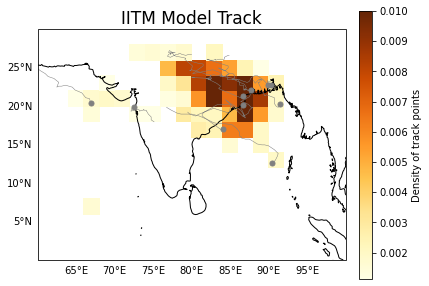

In [27]:
figIITM = positionDensityHistogram_model(hits_iitm, mapLonFor_iitm, mapLatFor_iitm, True, .001, .01, 'grey', 'IITM Model Track')


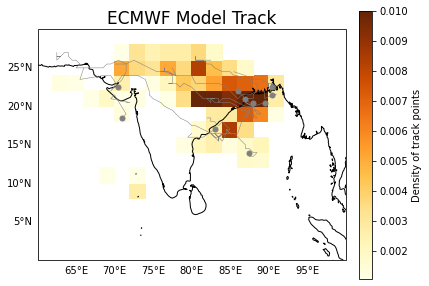

In [28]:
figECMWF = positionDensityHistogram_model(hits_ecmwf, mapLonFor_ecmwf, mapLatFor_ecmwf, True, .001, .01, 'grey', 'ECMWF Model Track')


In [29]:
def positionDensityHistogram_obs(tracks, lonArray, latArray, densityTorF, minval, maxval, inputColor, mapTitle='Track', maxY=9):
    fig = plt.figure(figsize=[6, 6])

    #plt.subplot(1, 2, 1)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([82, 87, 15, 22])
    #ax.stock_img()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    gl.top_labels = False
    #gl.ylabels_right = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines =False
    
    if densityTorF == True:
        plt.hist2d(lonArray, latArray, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = minval, vmax = maxval, cmap = plt.cm.YlOrBr)
        plt.title(mapTitle, fontsize=17)
    else:
        plt.hist2d(lonArray, latArray, bins=[40,30], range=[[60, 100], [0, 30]], density = False, cmin = 1, vmax = maxY, cmap = plt.cm.jet)
        plt.title(mapTitle, fontsize=17)
     
    for arr in tracks: #for observation there's one less layer of nesting
        
        plt.plot(arr[0,2],arr[0,3],
                     color=inputColor,  marker='.', markersize=10,
                     transform=ccrs.Geodetic(),
                    )
        plt.plot(arr[:,2],arr[:,3],
                     color=inputColor, linewidth=0.5,linestyle='solid',
                     transform=ccrs.Geodetic(),
                    )

    plt.colorbar(fraction=0.04, pad=0.04).set_label('Density of track points')
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.show()

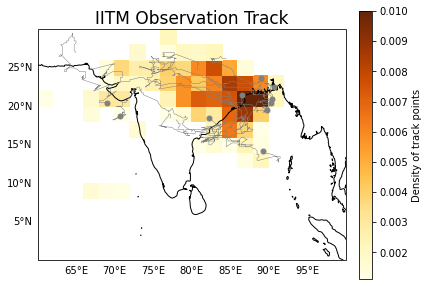

In [30]:
positionDensityHistogram_obs(obs, mapLonObs_iitm, mapLatObs_iitm, True, .001, .01, 'grey', 'IITM Observation Track')
#NOT using these (pt 1/2)

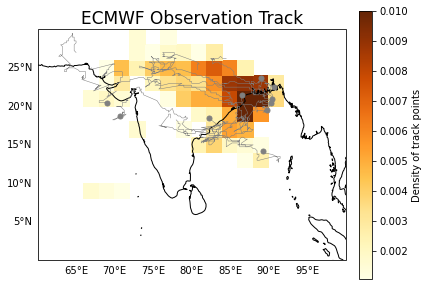

In [31]:
positionDensityHistogram_obs(obs, mapLonObs_ecmwf, mapLatObs_ecmwf, True, .001, .01, 'grey', 'ECMWF Observation Track')
#NOT using these (pt 2/2)

# observation

In [32]:
len(common_hits)

102

In [33]:
lonObs = []
latObs = []
for date in common_hits:
    indexObs = getIndexObs(linesinfo, date)
    trackdat = trackso[indexObs]
    for elem in trackdat:
        lonObs.append(elem[2])
        latObs.append(elem[3])

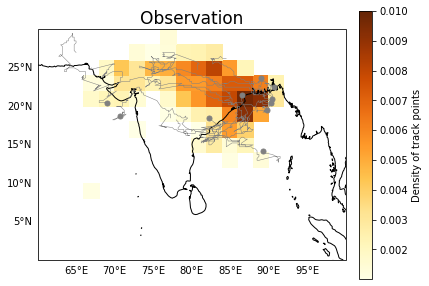

In [34]:
#OBSERVATION ERA5
figObs = plt.figure(figsize=[6, 6])
#genesis points marker size
markersizeg = 10

#plt.subplot(1, 2, 1)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([50, 95, 0, 35])
#ax.set_extent([65, 80, 10, 25])
#ax.stock_img()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False

plt.hist2d(lonObs, latObs, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)
plt.title('Observation', fontsize=17)
plt.colorbar(fraction=0.04, pad=0.04).set_label('Density of track points')


for date in [x for x in iitm_hits if x[:4] == '2007']:
    indexObs = getIndexObs(linesinfo, date)

    trackdat = trackso[indexObs]
    
    #plot genesis point: caution: it must correspond to genesis time of forecast
    plt.plot(trackdat[0][2],trackdat[0][3],
             color='gray',  marker='.', markersize=markersizeg,
             transform=ccrs.Geodetic(),
            )

    #make point along track for each day
    plt.plot(trackdat[:,2],trackdat[:,3],
                 color='gray', linewidth=0.5,linestyle='solid',
                 transform=ccrs.Geodetic(),
                )

# in one figure

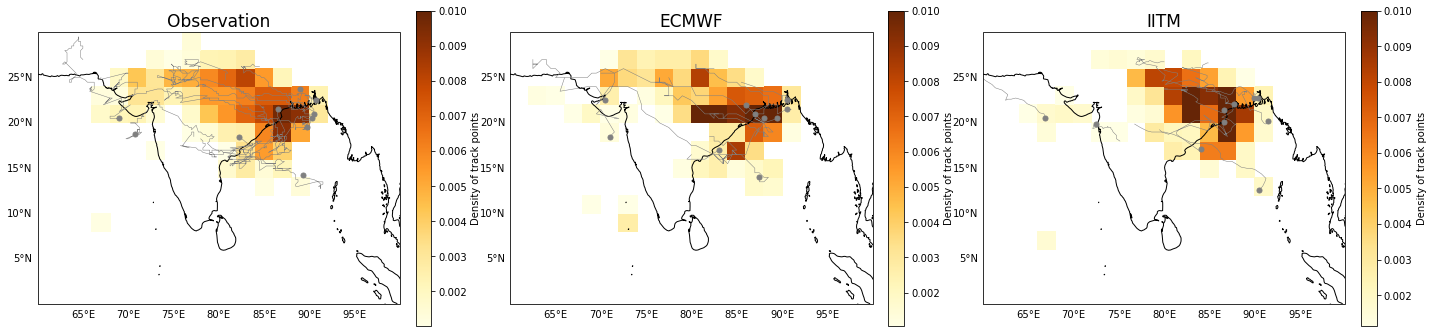

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[24,24])

#ax11 = plt.axes(ax1, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_extent([50, 95, 0, 35])
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False
gl1.xlines = False
gl1.ylines = False

#ax2 = plt.axes(ax2, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_extent([50, 95, 0, 35])
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
gl2.xlines = False
gl2.ylines = False

#ax3 = plt.axes(ax3, projection=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_extent([50, 95, 0, 35])
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl3.top_labels = False
gl3.right_labels = False
gl3.xlines = False
gl3.ylines =False

histObs = ax1.hist2d(lonObs, latObs, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)
ax1.set_title('Observation', fontsize=17)
fig.colorbar(histObs[3], ax=ax1, fraction=0.04, pad=0.04).set_label("Density of track points")

for date in [x for x in iitm_hits if x[:4] == '2007']:
    indexObs = getIndexObs(linesinfo, date)

    trackdat = trackso[indexObs]
    
    #plot genesis point: caution: it must correspond to genesis time of forecast
    ax1.plot(trackdat[0][2],trackdat[0][3],
             color='gray',  marker='.', markersize=markersizeg,
             transform=ccrs.Geodetic(),
            )

    #make point along track for each day
    ax1.plot(trackdat[:,2],trackdat[:,3],
                 color='gray', linewidth=0.5,linestyle='solid',
                 transform=ccrs.Geodetic(),
                )

histECMWF = ax2.hist2d(mapLonFor_ecmwf, mapLatFor_ecmwf, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)
ax2.set_title('ECMWF', fontsize=17)
fig.colorbar(histECMWF[3], ax=ax2, fraction=0.04, pad=0.04).set_label("Density of track points")

for arr in hits_ecmwf: #for the models there's one extra layer of nesting
        for i in range(0, len(arr)):
            trackdat = arr[i]
            ax2.plot(trackdat[0,2],trackdat[0,3],
                         color='gray',  marker='.', markersize=10,
                         transform=ccrs.Geodetic(),
                        )
            ax2.plot(trackdat[:,2],trackdat[:,3],
                         color='gray', linewidth=0.5,linestyle='solid',
                         transform=ccrs.Geodetic(),
                        )

histIITM = ax3.hist2d(mapLonFor_iitm, mapLatFor_iitm, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)
ax3.set_title('IITM', fontsize=17)
fig.colorbar(histIITM[3], ax=ax3, fraction=0.04, pad=0.04).set_label("Density of track points")

for arr in hits_iitm: #for the models there's one extra layer of nesting
        for i in range(0, len(arr)):
            trackdat = arr[i]
            ax3.plot(trackdat[0,2],trackdat[0,3],
                         color='gray',  marker='.', markersize=10,
                         transform=ccrs.Geodetic(),
                        )
            ax3.plot(trackdat[:,2],trackdat[:,3],
                         color='gray', linewidth=0.5,linestyle='solid',
                         transform=ccrs.Geodetic(),
                        )
            
plt.savefig('Figures/contextual_density_and_tracks.pdf', format='pdf', bbox_inches='tight')